In [ ]:
import pandas as pd
import scanpy as sc
import numpy as np
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(0)
import geopandas as gpd
from matplotlib.patheffects import withStroke
import os
from datetime import datetime
from scipy.sparse import csc_matrix
from scipy.io import savemat
import dill
import json
import gseapy
import matplotlib as mpl
import math
import scipy
import plotly.express as px
from adjustText import adjust_text
from statsmodels.stats.multitest import multipletests
import session_info2
import tifffile as tiff

from shapely.geometry import LineString
from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")

import gseapy as gp
import sys
shedding_paper_utils = "/mnt/x/Common/Lab_Papers/shedding_potential/utils"
sys.path.append(shedding_paper_utils)
import plot_gsea
import importlib

my_path = os.getcwd()

mpl.rcParams['pdf.fonttype'] = 42 # to edit text in Illustrator
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams.update({
    "font.size": 14,    
    "axes.titlesize": 16,    
    "axes.labelsize": 14,  
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,  
    "legend.fontsize": 14
})
LOAD_ARIAL = True
if LOAD_ARIAL:
    # set the default font to Arial
    from matplotlib.font_manager import FontProperties, fontManager
    from matplotlib import rcParams
    # Path to Arial font
    arial_path = '/mnt/x/common/joint_projects/spatial_celiac/utils/Arial.ttf'

    # Define font properties with the specific path
    arial_font = FontProperties(fname=arial_path)
    fontManager.addfont(arial_path)

    # Set the font as the default for all text elements
    rcParams['font.family'] = arial_font.get_family()
    rcParams['font.sans-serif'] = [arial_font.get_name()]

fast_load = True
if fast_load:
    fast_load_prefix = "/mnt/d/celiac_files/"
else:   
    fast_load_prefix = ""

In [2]:
joint_ad_path = fast_load_prefix+'all_ad_w_annotations_UMI100_leiden1.5.dill'#'joint_ad.dill'

with open(joint_ad_path, 'rb') as f:
    all_ad = dill.load(f)

In [3]:
raw_ad_path = fast_load_prefix+'joint_ad.dill'
with open(raw_ad_path, 'rb') as f:
    raw_ad = dill.load(f)

In [4]:
ct_path = "/mnt/x/Common/Joint_projects/spatial_celiac/visiumhd_experiment1/5_outs/CT/"
ct_path_08 = ct_path+"/binned_outputs/square_008um/"
scalefactor_path = ct_path_08+"/spatial/scalefactors_json.json"
scalefactors_ct = pd.read_json(scalefactor_path, typ='series')

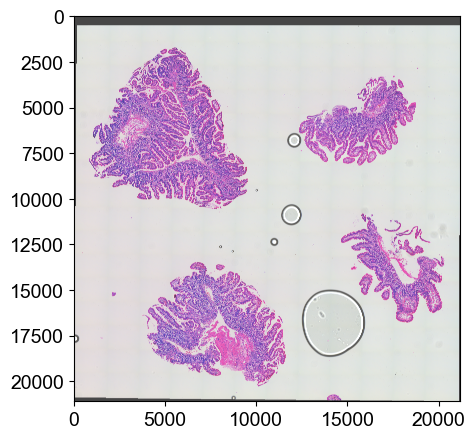

In [5]:
# load image and plot pixels according to clusters
ct_image_path = f"../visiumhd_experiment1/4_files_for_processing/brightened_Celiac_slide2-6_merged_celiac_slide2-6_ch00.tif"
ct_image = tiff.imread(ct_image_path)
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(ct_image, cmap='gray')
plt.show()

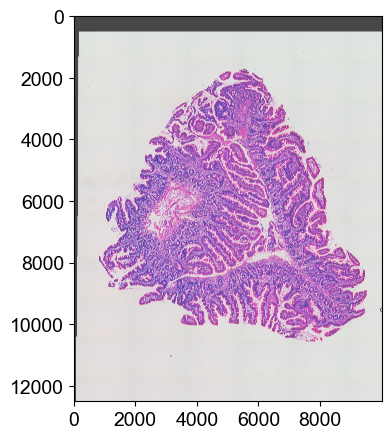

In [6]:
ct_image_cropped = ct_image[:12500, :10000]
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(ct_image_cropped, cmap='gray')
plt.show()

In [7]:
# select pt to show
st33_ad = raw_ad[raw_ad.obs.sample_name == "ST_033"].copy()
st33_ad

AnnData object with n_obs × n_vars = 81477 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'cell_x_um', 'cell_y_um', 'geometry', 'sample_name', 'macrozone', 'MM_LP_crypt', 'brunner', 'villus', 'immune', 'lowest_lumen', 'crypt_base', 'pixel_class', 'bc', 'slide', 'sum_of_umis', 'block_id', 'pt', 'age', 'sex', 'group', 'ttg', 'inflammation_bulb', 'inflammation_2nd_part', 'visium_batch', 'dv200', 'uscd', 'block_name', 'notes', 'median_sum_of_umis', 'crypt_villi_part'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'
    layers: 'counts', 'mat_norm', 'log_norm'

In [8]:
# Define a dictionary mapping cell types to specific colors
pixel_class_palette = {
    "epithelium":"#24dbff",
    "non_epithelium": "#e59abb",
}

In [9]:
# create dir for fig if not exists
cell_types_fig_save_path = os.getcwd()+"/figures/supp_fig_cell_types"
if not os.path.exists(cell_types_fig_save_path):
    os.makedirs(cell_types_fig_save_path)

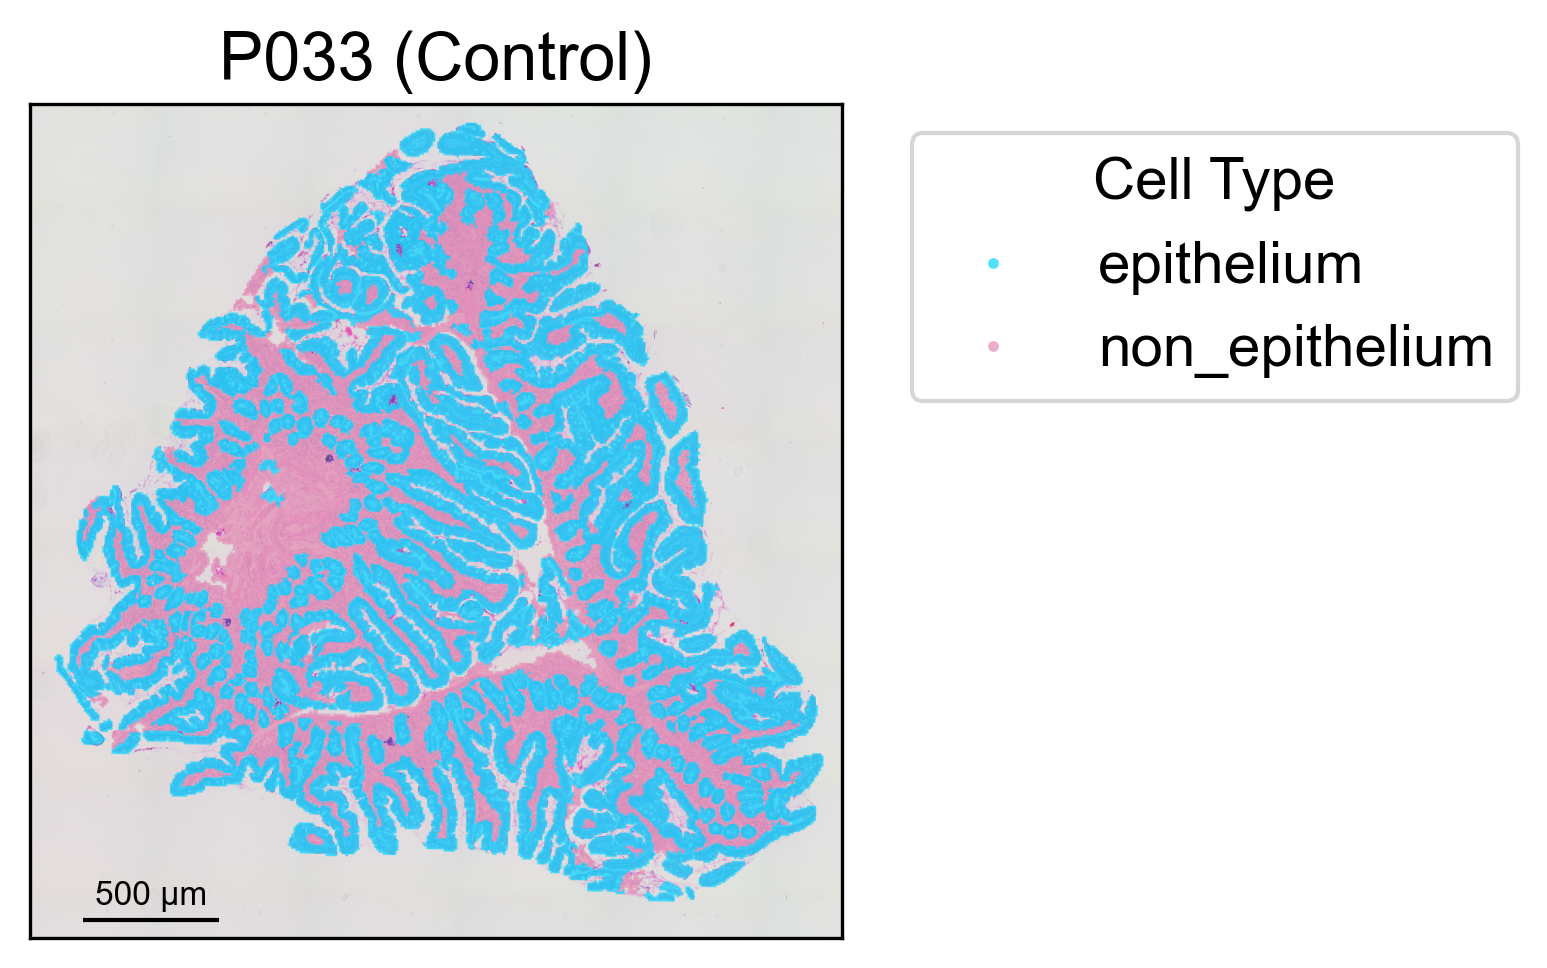

In [10]:
RASTERIZE = True
if RASTERIZE:
    raster_str = "_rasterized"
else:
    raster_str = "_no_rasterized"
LEGEND = True
if LEGEND:
    legend_str = "_with_legend"
else:
    legend_str = "_no_legend"

fig, ax = plt.subplots(figsize=(5,5), dpi=300)
ax.imshow(ct_image_cropped)

sns.scatterplot(st33_ad.obs, x='pxl_col_in_fullres', y='pxl_row_in_fullres', hue='pixel_class',
 palette=pixel_class_palette, alpha=0.8, ax=ax, edgecolor=None,s=0.4)
# rasterize
if RASTERIZE:
    for collection in ax.collections:
        collection.set_rasterized(True)

# legend outside
if LEGEND:
    plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=4)
else:
    plt.legend([],[], frameon=False)
plt.title("P033 (Control)")
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")

# make spines invisible
for spine in ax.spines.values():
    spine.set_visible(True)

plt.tight_layout()

# crop
y_min, y_max = 1500, 11000
x_min, x_max = 500, 9750

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_max, y_min)  # Invert y-axis

# add scalebar
scalebar_length_um = 500
start_bar_x = 1100
scalebar_y = y_max - 200

end_bar_x = start_bar_x + scalebar_length_um / scalefactors_ct['microns_per_pixel']

ax.plot([start_bar_x, end_bar_x], [scalebar_y, scalebar_y], color='black', linewidth=1, solid_capstyle='butt')
ax.text((start_bar_x + end_bar_x) / 2, scalebar_y-100, f"{scalebar_length_um} µm",
        ha='center', va='bottom', color='black', fontsize=8)

plt.show()

# export to PDF
fig.savefig(cell_types_fig_save_path+"/ST033_pixel_types"+raster_str+legend_str+".pdf", bbox_inches='tight')

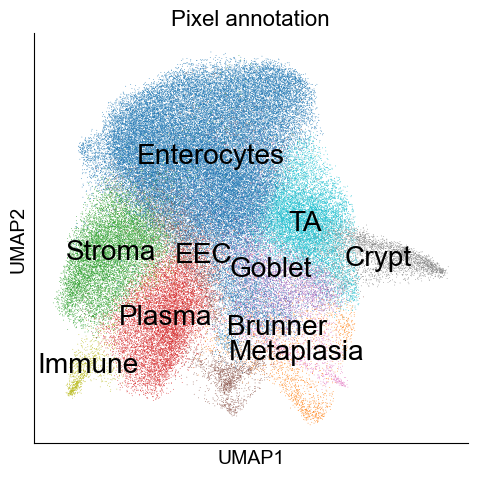

In [11]:
# Define a dictionary mapping cell types to specific colors
cell_type_palette = {
    "Enterocytes": "#1f77b4",
    "TA": "#17becf",
    "Stroma": "#2ca02c",
    "Plasma": "#d62728",
    "Goblet": "#9467bd",
    "EEC": "#8c564b",
    "Brunner": "#e377c2",
    "Crypt": "#7f7f7f",
    "Immune": "#bcbd22",
    "Metaplasia": "#ff7f0e",
}

fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.umap(all_ad, color=['cell_type_lvl1'], palette=cell_type_palette, ncols=2, legend_loc='on data', legend_fontweight='heavy',
             legend_fontsize='x-large', ax=ax, show=False)
# Add white outline to text
# for text in ax.texts:
#     text.set_path_effects([withStroke(linewidth=2, foreground='white')])

plt.title("Pixel annotation")
sns.despine()
plt.tight_layout()
plt.show()

# rasterize
for coll in ax.collections:
        coll.set_rasterized(True)
        
# export to PDF
fig.savefig(cell_types_fig_save_path+"/Supp_Fig_umap_cell_types_visiumHD.pdf", bbox_inches='tight')

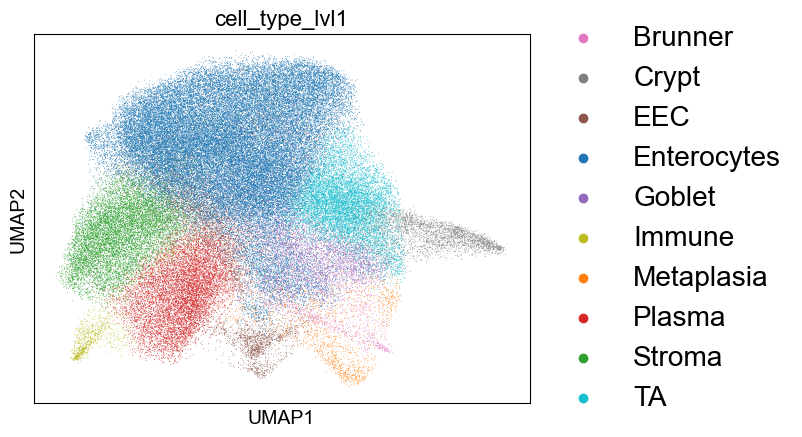

In [12]:
sc.pl.umap(all_ad, color=['cell_type_lvl1'], palette=cell_type_palette, ncols=2,legend_fontweight='heavy',
             legend_fontsize='x-large',)

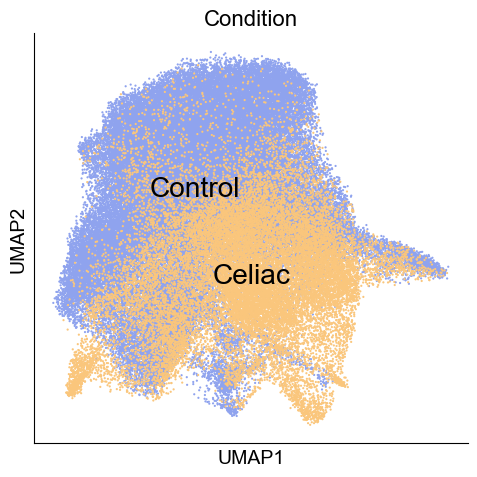

In [13]:
diagnosis_palette = [ "#fac67c","#8fa3ee"]  # Control: blue, CeD: orange
fig,ax = plt.subplots(figsize=(5,5))
sc.pl.umap(all_ad, color=['group'], palette=diagnosis_palette, legend_loc='on data', 
           size=10, alpha=1, ax=ax,show=False, legend_fontweight='heavy', legend_fontsize='x-large')
for text in ax.texts:
    # text.set_path_effects([withStroke(linewidth=2, foreground='white')])
    text.set_text(text.get_text().capitalize())
plt.title("Condition")
sns.despine()
plt.tight_layout()
plt.show()

# rasterize
for coll in ax.collections:
        coll.set_rasterized(True)

# export to PDF
fig.savefig(cell_types_fig_save_path+"/Supp_fig_umap_diagnosis_visiumHD.pdf", bbox_inches='tight')

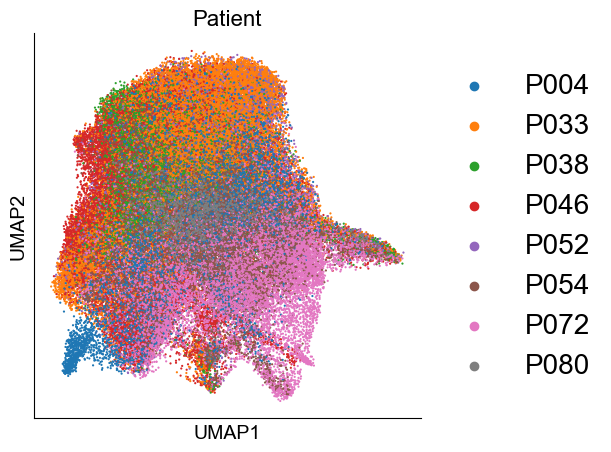

In [14]:
# diagnosis_palette = [ "#fac67c","#8fa3ee"]  # Control: blue, CeD: orange
all_ad.obs['pt'] = all_ad.obs['pt'].str.replace("ST_", "P")
# drop B1
all_ad.obs['pt'] = all_ad.obs['pt'].str.replace("B1", "")
fig,ax = plt.subplots(figsize=(5,5))
sc.pl.umap(all_ad, color=['pt'], 
           size=10, alpha=1, ax=ax,show=False, legend_fontweight='heavy', legend_fontsize='x-large')
plt.title("Patient")
sns.despine()
# plt.tight_layout()
plt.show()

# rasterize
for coll in ax.collections:
        coll.set_rasterized(True)

# export to PDF
fig.savefig(cell_types_fig_save_path+"/Supp_fig_umap_pt_visiumHD_LEGEND.pdf", bbox_inches='tight')

In [15]:
# Perform differential gene expression analysis for cell types
sc.tl.rank_genes_groups(all_ad, groupby='cell_type_lvl1', method='wilcoxon', layer='log_norm')

# Save the plot
# dotplot_save_path = cell_types_fig_save_path + "/dotplot_cell_types.pdf"
# plt.savefig(dotplot_save_path, bbox_inches='tight')

In [16]:
ordered_cell_types = ["Enterocytes","TA","Crypt","Goblet","EEC",
"Metaplasia","Brunner","Stroma",
"Plasma","Immune"]

In [17]:
N_markers = 2
top_markers = {}
for cell_type in ordered_cell_types:#all_ad.obs['cell_type_lvl1'].unique():
    markers_df = sc.get.rank_genes_groups_df(all_ad, group=cell_type)
    top_genes_N = markers_df['names'].head(N_markers).tolist()
    top_markers[cell_type] = top_genes_N

top_markers_list = []
for markers in top_markers.values():
    top_markers_list.extend(markers)

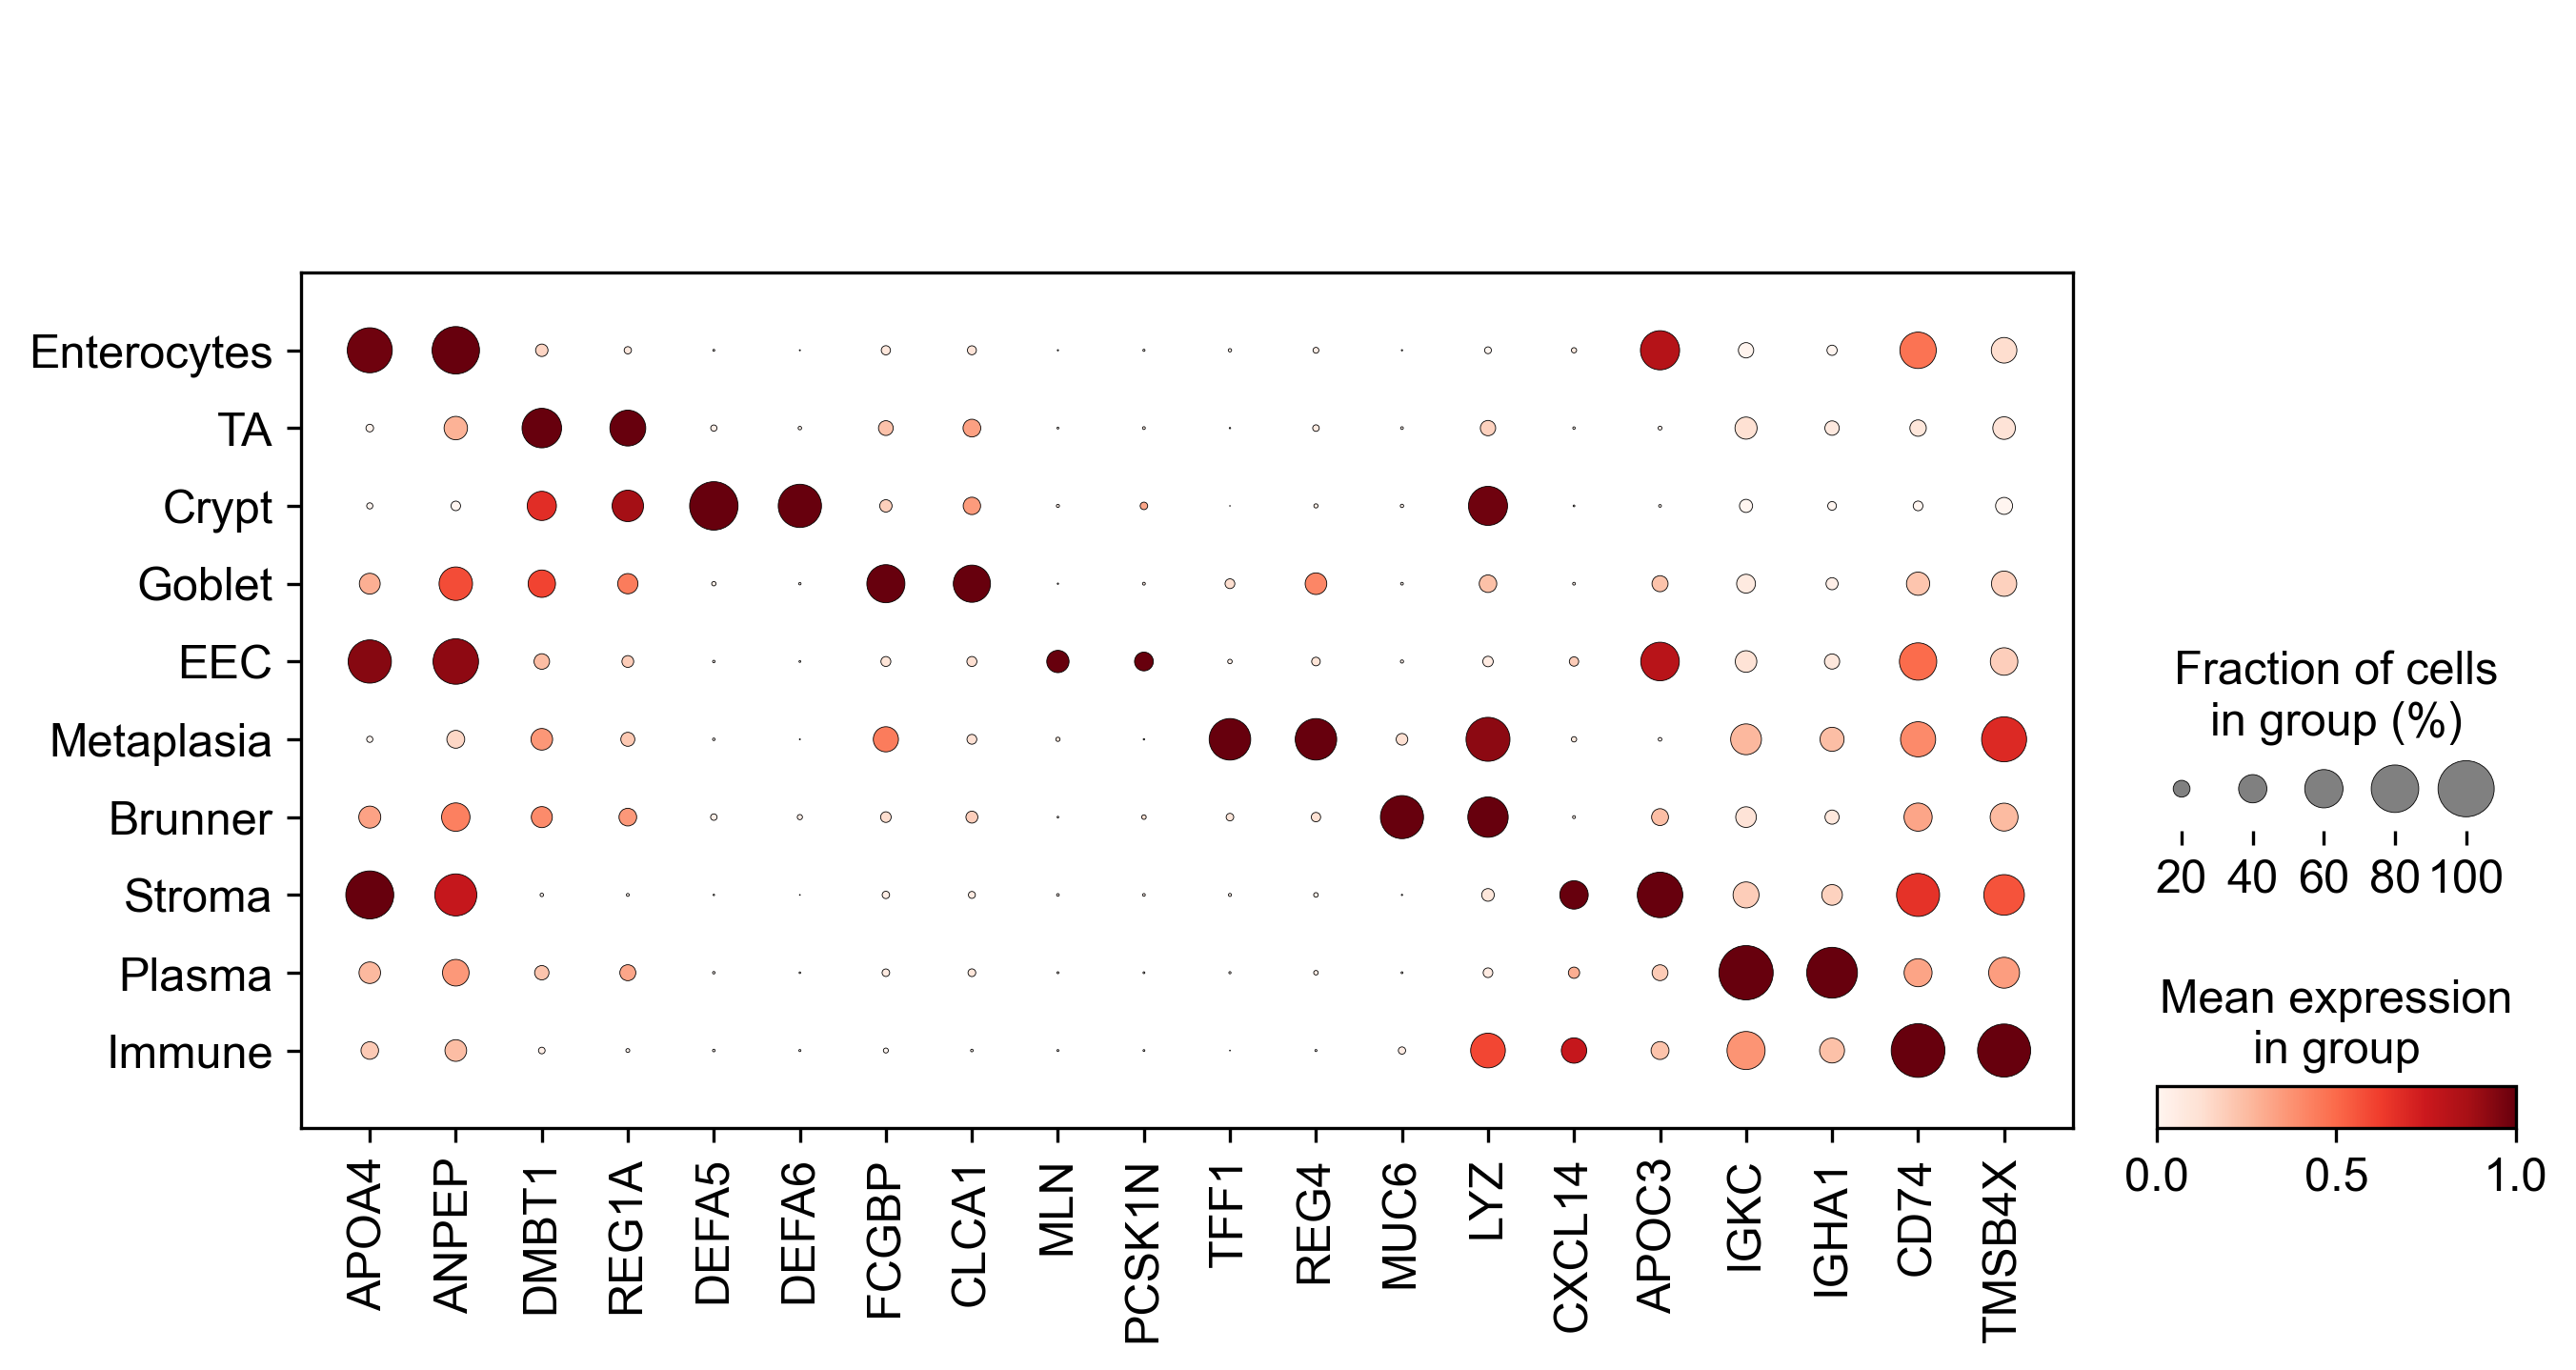

In [18]:
# Create a dot plot for the top-ranked genes
all_ad_tmp = all_ad.copy()

# reorder categories
all_ad_tmp.obs['cell_type_lvl1'] = all_ad_tmp.obs['cell_type_lvl1'].astype('category')
all_ad_tmp.obs['cell_type_lvl1'] = all_ad_tmp.obs['cell_type_lvl1'].cat.reorder_categories(ordered_cell_types, ordered=True)

fig,ax = plt.subplots(figsize=(10,5), dpi=300)
sc.pl.dotplot(all_ad_tmp, var_names=top_markers_list, groupby='cell_type_lvl1', layer='log_zscore',
                                standard_scale='var', show=False, ax=ax)
export_path = f"{cell_types_fig_save_path}/supp_fig_VHD_lvl1_celltypes_marker_genes_dotplot.pdf"
plt.gcf().savefig(export_path, bbox_inches='tight', dpi=300)
plt.show()

In [19]:
print(session_info2.session_info(dependencies=True))

anndata	0.12.2
pandas	2.3.2
scanpy	1.11.4
numpy	2.2.6
tqdm	4.67.1
seaborn	0.13.2
matplotlib	3.10.6
geopandas	1.1.1
scipy	1.15.3
dill	0.4.0
gseapy	1.1.10
plotly	6.3.0
adjustText	1.3.0
statsmodels	0.14.5
tifffile	2025.8.28
shapely	2.1.1
----	----
igraph	0.11.9
kiwisolver	1.4.9
sphinxcontrib-htmlhelp	2.1.0
tornado	6.5.2
numba	0.61.2
debugpy	1.8.16
cloudpickle	3.1.1
comm	0.2.3
matplotlib-inline	0.1.7
ipykernel	6.30.1
toolz	1.0.0
packaging	25.0
pytz	2025.2
six	1.17.0
PyYAML	6.0.2
legacy-api-wrap	1.4.1
llvmlite	0.44.0
jedi	0.19.2
asttokens	3.0.0
charset-normalizer	3.4.3
sphinxcontrib-applehelp	2.0.0
scikit-learn	1.7.1
jupyter_client	8.6.3
fonttools	4.59.2
prompt_toolkit	3.0.52
pyarrow	21.0.0
idna	3.10
setuptools	78.1.1
fsspec	2025.9.0
xarray	2025.9.0
crc32c	2.7.1
Pygments	2.19.2
pillow	11.3.0
stack-data	0.6.3
leidenalg	0.10.2
sphinxcontrib-devhelp	2.0.0
traitlets	5.14.3
pyparsing	3.2.3
session-info2	0.2.1
jupyter_core	5.8.1
numcodecs	0.15.1
executing	2.2.1
requests	2.32.5
decorator	5.2.1
url